In [1]:
import numpy as np
import tensorflow as tf
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist

Default GPU Device:/device:GPU:0
Instructions for updating:
non-resource variables are not supported in the long term


Relevant libraries are imported. Tensorflow is deprecated to version 1.14 so that tf.placeholders can be used and sessions can be run. MNIST dataset is used 

In [2]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
x=X_test
X_train=np.reshape(X_train,(X_train.shape[0],-1)).T
X_train=X_train/255
X_trai=X_train[:,0:50000]
X_dev=X_train[:,50000:60000]
X_test=X_test/255
X_test=np.reshape(X_test,(X_test.shape[0],-1)).T
Y=np.zeros((10,Y_train.shape[0]))
Ytt=np.zeros((10,Y_test.shape[0]))
y=Y_test
for i in range(Y_train.shape[0]):
    Y[Y_train[i],i]=1
for i in range(Y_test.shape[0]):
    Ytt[Y_test[i],i]=1    
Y_train=Y
Y_trai=Y_train[:,0:50000]
Y_dev=Y_train[:,50000:60000]
Y_test=Ytt
print(Y_dev)
print(X_train.shape)
print(X_dev.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
(784, 60000)
(784, 10000)


First the parameters are initialized. X and Y are initialized as placeholders with relevant sizes. Rank2 of their shapes are kept none so that they are flexible to changes in mini-batch sizes. A neural network of 3 layers is made. First hidden layer has 128 units, second has 64 units and the output layer has 10 units each one corresponding to a digit. Accordingly the weights are initialized. He initialization is used to speed up optimization.Xavier initialization can also be used.  

In [3]:
def initialize(nx,ny):
    X=tf.placeholder(tf.float64,[nx,None])
    Y=tf.placeholder(tf.float64,[ny,None])
    Theta1=tf.get_variable("Theta1",[128,nx],dtype=tf.float64,initializer=tf.compat.v1.keras.initializers.he_normal())#np.random.randn(128,nx)*np.sqrt(1/nx)
    Theta2=tf.get_variable("Theta2",[64,128],dtype=tf.float64,initializer=tf.compat.v1.keras.initializers.he_normal())
    Theta3=tf.get_variable("Theta3",[10,64],dtype=tf.float64,initializer=tf.compat.v1.keras.initializers.he_normal())
    parameters={
        "Theta1":Theta1,
        "Theta2":Theta2,
        "Theta3":Theta3,
    }
    return X,Y,parameters

Forward propagation is carried out. The activation functions for the two hidden layers is 'relu' and 'softmax' is used for the output layer. A3 is not calculated because the loss function takes in Z3 and directly converts it to corresponding softmax outputs.

In [4]:
def forward_prop(parameters,X):
    theta1=parameters["Theta1"]
    theta2=parameters["Theta2"]
    theta3=parameters["Theta3"]
    
    Z1=tf.matmul(theta1,X)
    A1=tf.nn.relu(Z1)
    Z2=tf.matmul(theta2,Z1)
    A2=tf.nn.relu(Z2)
    Z3=tf.matmul(theta3,A2)
    
    return Z3
    

The loss function is deployed and the loss is calculated. Labels correspond to the actual value and logits correspond to the linear functions that have been calculated using the previous layer. Both logits and labels must have the same shapes

In [33]:
def comp_cost(Y,Z3):
    logits=tf.transpose(Z3)
    labels=tf.transpose(Y)
    
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [40]:
def comp_cost_reg(Y,Z3,parameters,beta):
    logits=tf.transpose(Z3)
    labels=tf.transpose(Y)
    theta1 = tf.convert_to_tensor(parameters["Theta1"])
    theta2 = tf.convert_to_tensor(parameters["Theta2"])
    theta3 = tf.convert_to_tensor(parameters["Theta3"])
    
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    regularizer=tf.nn.l2_loss(theta1)+tf.nn.l2_loss(theta2)+tf.nn.l2_loss(theta3)                    
    cost=tf.reduce_mean(cost+(beta)*regularizer)
    
    return cost

Predict function is used for predicting individual images given by the user. It returns the predicted number based on the parameters that have been trained by the model.

In [16]:
def predict(X, parameters):
    
    Theta1 = tf.convert_to_tensor(parameters["Theta1"])
    Theta2 = tf.convert_to_tensor(parameters["Theta2"])
    Theta3 = tf.convert_to_tensor(parameters["Theta3"])
    
    params={
        "Theta1":Theta1,
        "Theta2":Theta1,
        "Theta3":Theta1,
    }
    
    x = tf.placeholder(tf.float64, [784,None])
    z1=tf.matmul(Theta1,x)
    a1=tf.nn.relu(z1)
    z2=tf.matmul(Theta2,z1)
    a2=tf.nn.relu(z2)
    z3=tf.matmul(Theta3,a2)    
    a3=tf.nn.softmax(tf.transpose(z3))
    p =tf.argmax(a3,axis=1)
    co=tf.reduce_max(a3,axis=1)
    sess = tf.Session()
    prediction,con = sess.run([p,co],feed_dict={x:X})
        
    return prediction,con

The model is brought together by using all the functions defined above. The loss is optimized using an Adam optimizer which includes both gradient descent with momentum and RMsprop. Mini-batch is used to speed up training. Epochs specify the number of passes per mini-batch. The cost of every 10th epoch is plotted and finally training and test set accuracy is printed

In [20]:
def model(X_train,Y_train,X_dev,Y_dev,X_test,Y_test,alpha,mini_size,nx,ny,epochs,printc):
    ops.reset_default_graph()
    X,Y,parameters=initialize(nx,ny)
    Z3=forward_prop(parameters,X)
    cost=comp_cost(Y,Z3)
    optimize=tf.train.AdamOptimizer().minimize(cost)
    costt=[]
    vcostt=[]
    init=tf.global_variables_initializer()
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)) as sess:
        
        sess.run(init)
        
        for i in range(epochs):
            e=0
            for j in range(0,X_train.shape[1],mini_size):
                Xt=X_train[:,j:j+100]
                Yt=Y_train[:,j:j+100]
                _,c=sess.run([optimize,cost],feed_dict={X:Xt,Y:Yt})
                e=e+(c/mini_size)
                costt.append(e)
            if printc and i%10==0:
                params=sess.run(parameters)
                Z3d=forward_prop(params,X_dev)
                vc=comp_cost(Y_dev,Z3d)    
                vcostt.append(vc.eval()/10000)
                print("Cost of epoch "+str(i)+"- "+str(e)+" Validation-cost:"+str(vc.eval()/10000))
                      
        plt.plot(np.squeeze(costt))
        plt.title('Training loss')
        plt.show() 
        plt.plot(np.squeeze(vcostt))
        plt.title('Validation loss')
        plt.show()
        parameters=sess.run(parameters)
        print("Training of parameters finished")
        
        pred=tf.equal(tf.argmax(Z3),tf.argmax(Y))
        accuracy=tf.reduce_mean(tf.cast(pred,"float"))
        print("Accuracy on training set: "+str(accuracy.eval({X:X_train,Y:Y_train})))
        print("Accuracy on dev set: "+str(accuracy.eval({X:X_dev,Y:Y_dev})))
        print("Accuracy on test set: "+str(accuracy.eval({X:X_test,Y:Y_test})))
        
        if accuracy.eval({X:X_test,Y:Y_test})>0.95:
            print("Task done! Significant accuracy achieved")
        
        return parameters
    

Cost of epoch 0- 2.7043529331535963 Validation-cost:2.2959049167211797e-05
Cost of epoch 10- 0.20296677566880192 Validation-cost:1.5242424366666752e-05
Cost of epoch 20- 0.09206096037817345 Validation-cost:1.7505949652638346e-05
Cost of epoch 30- 0.08674707326270419 Validation-cost:2.2687294243147417e-05
Cost of epoch 40- 0.06361296629807837 Validation-cost:2.5930957619858692e-05
Cost of epoch 50- 0.07376950240810946 Validation-cost:2.777916324542491e-05
Cost of epoch 60- 0.062482765529028796 Validation-cost:3.044331516567867e-05
Cost of epoch 70- 0.04683752133219048 Validation-cost:3.10681980249777e-05
Cost of epoch 80- 0.053624057393801536 Validation-cost:3.376049400173582e-05
Cost of epoch 90- 0.07050811585718181 Validation-cost:3.449683196887507e-05


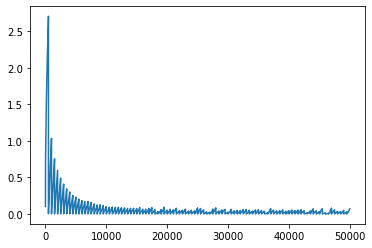

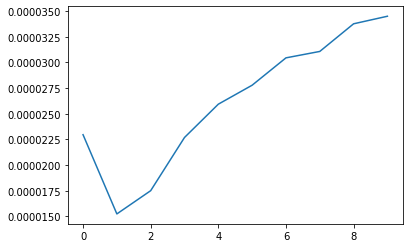

Training of parameters finished
Accuracy on training set: 0.99744
Accuracy on dev set: 0.9707
Accuracy on test set: 0.9676
Task done! Significant accuracy achieved


In [21]:
parameters=model(X_trai,Y_trai,X_dev,Y_dev,X_test,Y_test,alpha=0.001,mini_size=100,nx=X_train.shape[0],ny=Y_train.shape[0],epochs=100,printc=True)

As visible from the graphs, validation loss increases while training loss decreases. This means that the model is overfitting the data and therefore regularisation must be added. By doing this variance equivalent to 2% can be brought down. 

Some examples with predictions,given values and corresponding images are: 


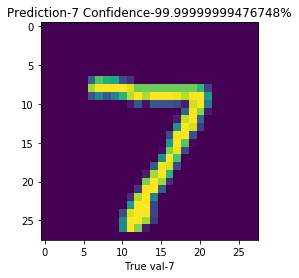

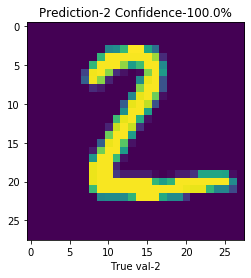

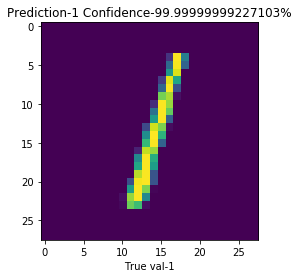

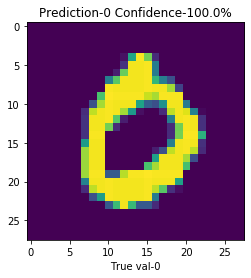

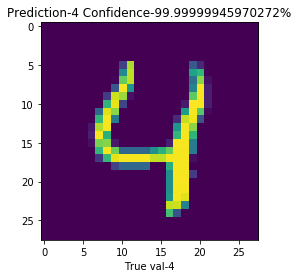

In [22]:
print("Some examples with predictions,given values and corresponding images are: ")
for i in range(5):    
    Xx=X_test[:,i]
    Xx=np.reshape(Xx,(784,1))
    p,c=predict(Xx,parameters)
    plt.imshow(x[i])
    plt.title('Prediction-'+str(np.squeeze(p))+' Confidence-'+str(np.squeeze(c)*100)+'%')
    plt.xlabel('True val-'+str(y[i]))
    plt.show()

In [46]:
def model_reg(X_train,Y_train,X_dev,Y_dev,X_test,Y_test,alpha,mini_size,nx,ny,epochs,printc,beta):
    ops.reset_default_graph()
    X,Y,parameters=initialize(nx,ny)
    Z3=forward_prop(parameters,X)
    cost=comp_cost_reg(Y,Z3,parameters,beta)
    optimize=tf.train.AdamOptimizer().minimize(cost)
    costt=[]
    vcostt=[]
    init=tf.global_variables_initializer()
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)) as sess:
        
        sess.run(init)
        
        for i in range(epochs):
            e=0
            for j in range(0,X_train.shape[1],mini_size):
                Xt=X_train[:,j:j+100]
                Yt=Y_train[:,j:j+100]
                _,c=sess.run([optimize,cost],feed_dict={X:Xt,Y:Yt})
                e=e+(c/mini_size)
                costt.append(e)
            if printc and i%10==0:
                params=sess.run(parameters)
                Z3d=forward_prop(params,X_dev)
                vc=comp_cost(Y_dev,Z3d)    
                vcostt.append(vc.eval())
                print("Cost of epoch "+str(i)+"- "+str(e)+" Validation-cost:"+str(vc.eval()))
                      
        plt.plot(np.squeeze(costt))
        plt.title('Training loss')
        plt.show() 
        plt.plot(np.squeeze(vcostt))
        plt.title('Validation loss')
        plt.show()
        parameters=sess.run(parameters)
        print("Training of parameters finished")
        
        pred=tf.equal(tf.argmax(Z3),tf.argmax(Y))
        accuracy=tf.reduce_mean(tf.cast(pred,"float"))
        print("Accuracy on training set: "+str(accuracy.eval({X:X_train,Y:Y_train})))
        print("Accuracy on dev set: "+str(accuracy.eval({X:X_dev,Y:Y_dev})))
        print("Accuracy on test set: "+str(accuracy.eval({X:X_test,Y:Y_test})))
        
        if accuracy.eval({X:X_test,Y:Y_test})>0.95:
            print("Task done! Significant accuracy achieved")
        
        return parameters
    

Cost of epoch 0- 4.418844278523502 Validation-cost:0.2312483084643126
Cost of epoch 10- 0.9605827212426287 Validation-cost:0.10301631222657727
Cost of epoch 20- 0.7166392804648811 Validation-cost:0.09782550691749152
Cost of epoch 30- 0.6648235700738383 Validation-cost:0.0928410547791675
Cost of epoch 40- 0.63545713589996 Validation-cost:0.09167812798850962
Cost of epoch 50- 0.6143655671821014 Validation-cost:0.08925027506072512
Cost of epoch 60- 0.5977398222693463 Validation-cost:0.08589942239476431
Cost of epoch 70- 0.582700982347059 Validation-cost:0.08543272254700147
Cost of epoch 80- 0.5718445290071767 Validation-cost:0.08253277164653826
Cost of epoch 90- 0.569339177652334 Validation-cost:0.08030978419995238
Cost of epoch 100- 0.5618349325022244 Validation-cost:0.07998047871000386
Cost of epoch 110- 0.5560345959416984 Validation-cost:0.07877900764626829
Cost of epoch 120- 0.5525252584884571 Validation-cost:0.07782348336220582
Cost of epoch 130- 0.5520702246829393 Validation-cost:0.

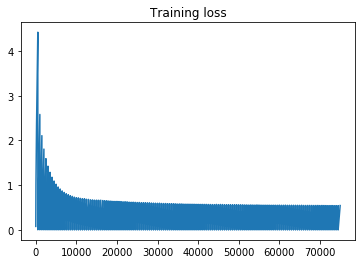

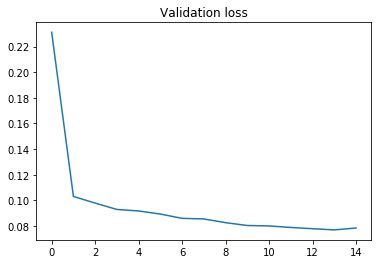

Training of parameters finished
Accuracy on training set: 0.9913
Accuracy on dev set: 0.9759
Accuracy on test set: 0.9775
Task done! Significant accuracy achieved


In [48]:
paramsr=model_reg(X_trai,Y_trai,X_dev,Y_dev,X_test,Y_test,alpha=0.001,mini_size=100,nx=X_train.shape[0],ny=Y_train.shape[0],epochs=150,printc=True,beta=0.0005)

By adding regularisation term the bias has increased but the variance is decreased significantly. The model is ot overfitting the data and is performing better on the test set.

Some examples with predictions,given values and corresponding images are: 


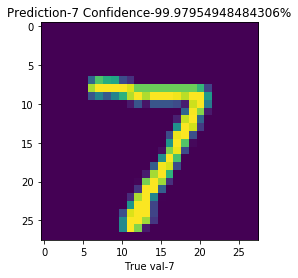

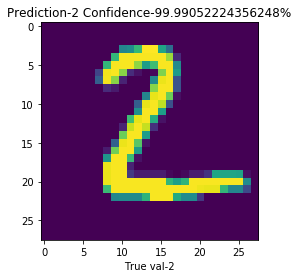

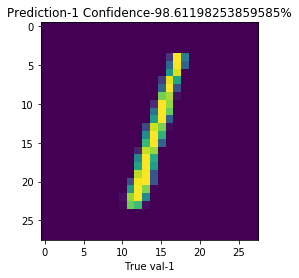

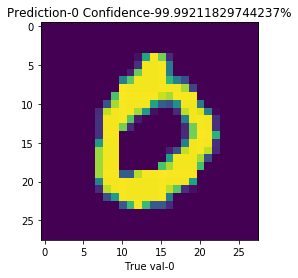

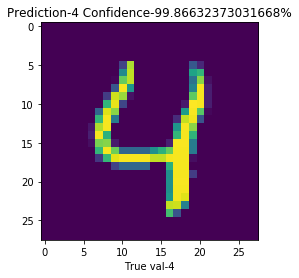

In [49]:
print("Some examples with predictions,given values and corresponding images are: ")
for i in range(5):    
    Xx=X_test[:,i]
    Xx=np.reshape(Xx,(784,1))
    p,c=predict(Xx,paramsr)
    plt.imshow(x[i])
    plt.title('Prediction-'+str(np.squeeze(p))+' Confidence-'+str(np.squeeze(c)*100)+'%')
    plt.xlabel('True val-'+str(y[i]))
    plt.show()